In [1]:
#Authors: Akbota Assan (A69037121), Devana Perupurayil (A69034326), Melissa Medina-Peregrina (A59016508)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.stats import norm
import scipy.stats
from sklearn.metrics import auc

In [2]:
detector_A = pd.read_csv('DetectorA.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_B = pd.read_csv('DetectorB.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_C = pd.read_csv('DetectorC.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_Target = pd.read_csv('DetectorTarget.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])

In [3]:
detector_A

,ID,cnn_score,Energy
0,371804.0,0.302,2614.488
1,594581.0,0.600,1705.200
2,1032837.0,0.481,1267.713
3,959143.0,0.154,2615.730
4,930779.0,0.093,1699.004
...,...,...,...
39995,440702.0,0.006,1465.075
39996,970685.0,0.018,1350.027
39997,226138.0,0.564,1126.152
39998,374147.0,0.587,1350.153


In [4]:
A_min_energy = detector_A["Energy"].min()
A_max_energy = detector_A["Energy"].max()
B_min_energy = detector_B["Energy"].min()
B_max_energy = detector_B["Energy"].max()
C_min_energy = detector_C["Energy"].min()
C_max_energy = detector_C["Energy"].max()
Target_min_energy = detector_Target["Energy"].min()
Target_max_energy = detector_Target["Energy"].max()

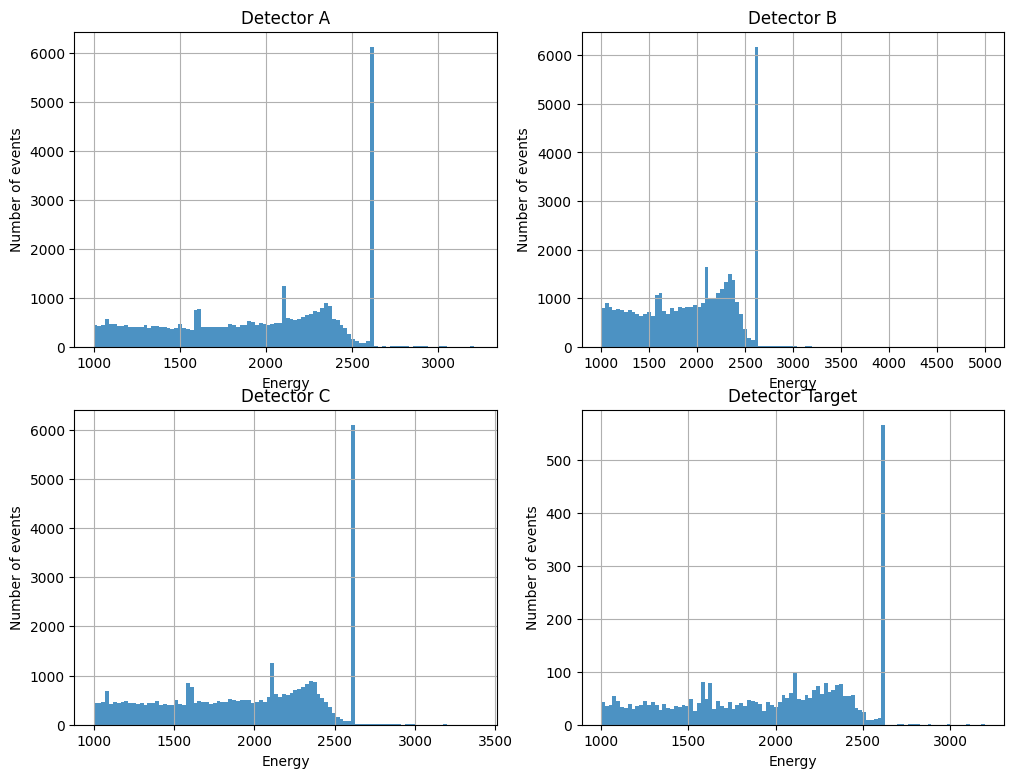

In [5]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8, range=(A_min_energy, A_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8, range=(B_min_energy, B_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8, range=(C_min_energy, C_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8, range=(Target_min_energy, Target_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target')
plt.grid(True)

True Positive Rate: 0.501


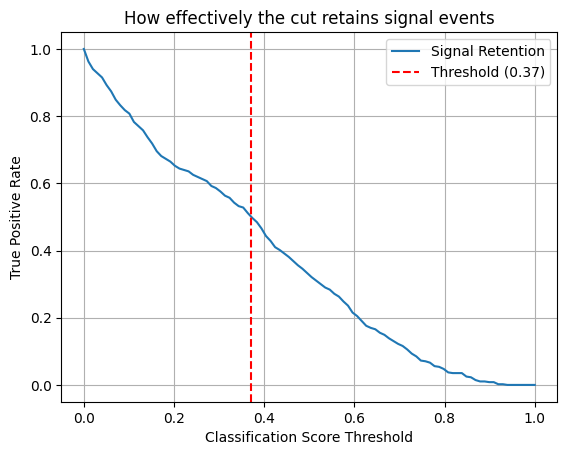

In [6]:
#Step 2

#Identify energy range around the 1592 keV peak
Peak_A = (detector_A["Energy"]>=1589)&(detector_A["Energy"]<=1595)
Peak_A_events = detector_A[Peak_A] 

#Take values with cnn_score above 90% as acceptable threshold
Threshold = np.percentile(Peak_A_events["cnn_score"], 50)
#print(Threshold)
Thresholds = np.linspace(0, 1, 100)

True_Positive = len(Peak_A_events[Peak_A_events["cnn_score"]>=Threshold])
False_Negative = len(Peak_A_events[Peak_A_events["cnn_score"]<Threshold])
#print(False_Negative)
Signal = True_Positive+False_Negative
True_Positive_Rate = True_Positive/Signal
print(f"True Positive Rate: {True_Positive_Rate:.3f}")
        
# Plot the signal retention as a function of threshold
plt.plot(Thresholds, [len(Peak_A_events[Peak_A_events["cnn_score"] >= t]) / len(Peak_A_events) for t in Thresholds], label="Signal Retention")
plt.axvline(Threshold, color='r', linestyle='--', label=f"Threshold ({Threshold:.2f})")
plt.xlabel("Classification Score Threshold")
plt.ylabel("True Positive Rate")
plt.title("How effectively the cut retains signal events")
plt.legend()
plt.grid()
plt.show()

False Positive Rate: 0.062
Area under curve: 0.860


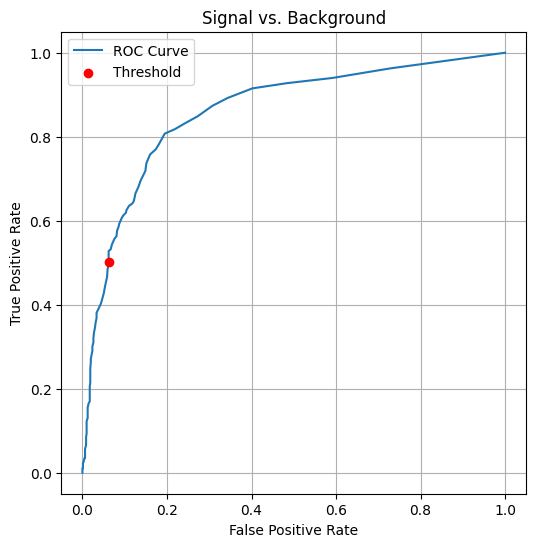

In [7]:
#Step 3

#Identify energy range around the 2103 keV peak
Peak_B = (detector_B["Energy"]>=2100)&(detector_B["Energy"]<=2106)
Peak_B_events = detector_B[Peak_B]

#Events in the 2103 keV region

False_positive = len(Peak_B_events[Peak_B_events["cnn_score"] >= Threshold])
True_Negative = len(Peak_B_events[Peak_B_events["cnn_score"]<Threshold]) 
Background = False_positive+True_Negative
False_Positive_Rate = False_positive/Background
print(f"False Positive Rate: {False_Positive_Rate:.3f}")

#Different thresholds
#thresholds = np.linspace(0, 1, 100)
TPR_values = [(Peak_A_events["cnn_score"] >= t).sum()/Signal for t in Thresholds]
FPR_values = [(Peak_B_events["cnn_score"] >= t).sum()/Background for t in Thresholds]

ROC_AUC = auc(FPR_values,TPR_values)
print(f"Area under curve: {ROC_AUC:.3f}")

plt.figure(figsize=(6, 6))
plt.plot(FPR_values, TPR_values, label="ROC Curve")
plt.scatter(False_Positive_Rate, True_Positive_Rate, color="red", label="Threshold", zorder=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Signal vs. Background")
plt.legend()
plt.grid()
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/rt/hh_hxvxx60x6xkktcx2rmf2r0000gn/T/ipykernel_25722/2641089022.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF''\n''($\mu=2039$ keV, $\sigma=1$ keV)', color='r')


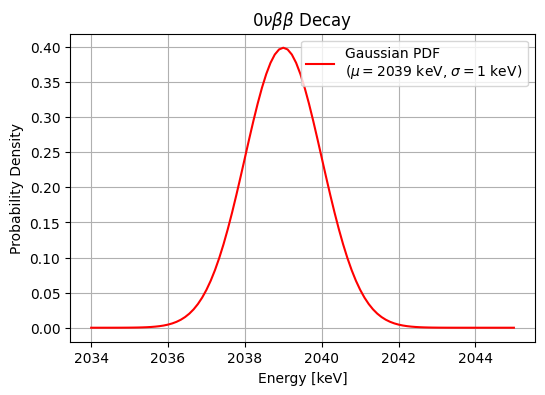

In [8]:
#Step 4

#Gaussian parameters sigma and peak energy
sigma = 1 
mu = 2039
E = np.linspace(2034, 2045, 100)

Gaussian_PDF = norm.pdf(E,mu,sigma)

plt.figure(figsize=(6, 4))
plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF''\n''($\mu=2039$ keV, $\sigma=1$ keV)', color='r')
plt.legend(fontsize=8)
plt.xlabel("Energy [keV]")
plt.ylabel("Probability Density")
plt.title("$0\\nu\\beta\\beta$ Decay")
plt.legend()
plt.grid()
plt.show()

## Step 5

We will be removing data points that do not pass a certain theshold calculated earlier. 

In [55]:
detectorA_cut = detector_A[
    (detector_A['cnn_score'] >= Threshold)
]
detectorB_cut = detector_B[
    (detector_B['cnn_score'] >= Threshold)
]

detectorC_cut = detector_C[
    (detector_C['cnn_score'] >= Threshold)
]

target_cut = detector_Target[
    (detector_Target['cnn_score'] >= Threshold)
]


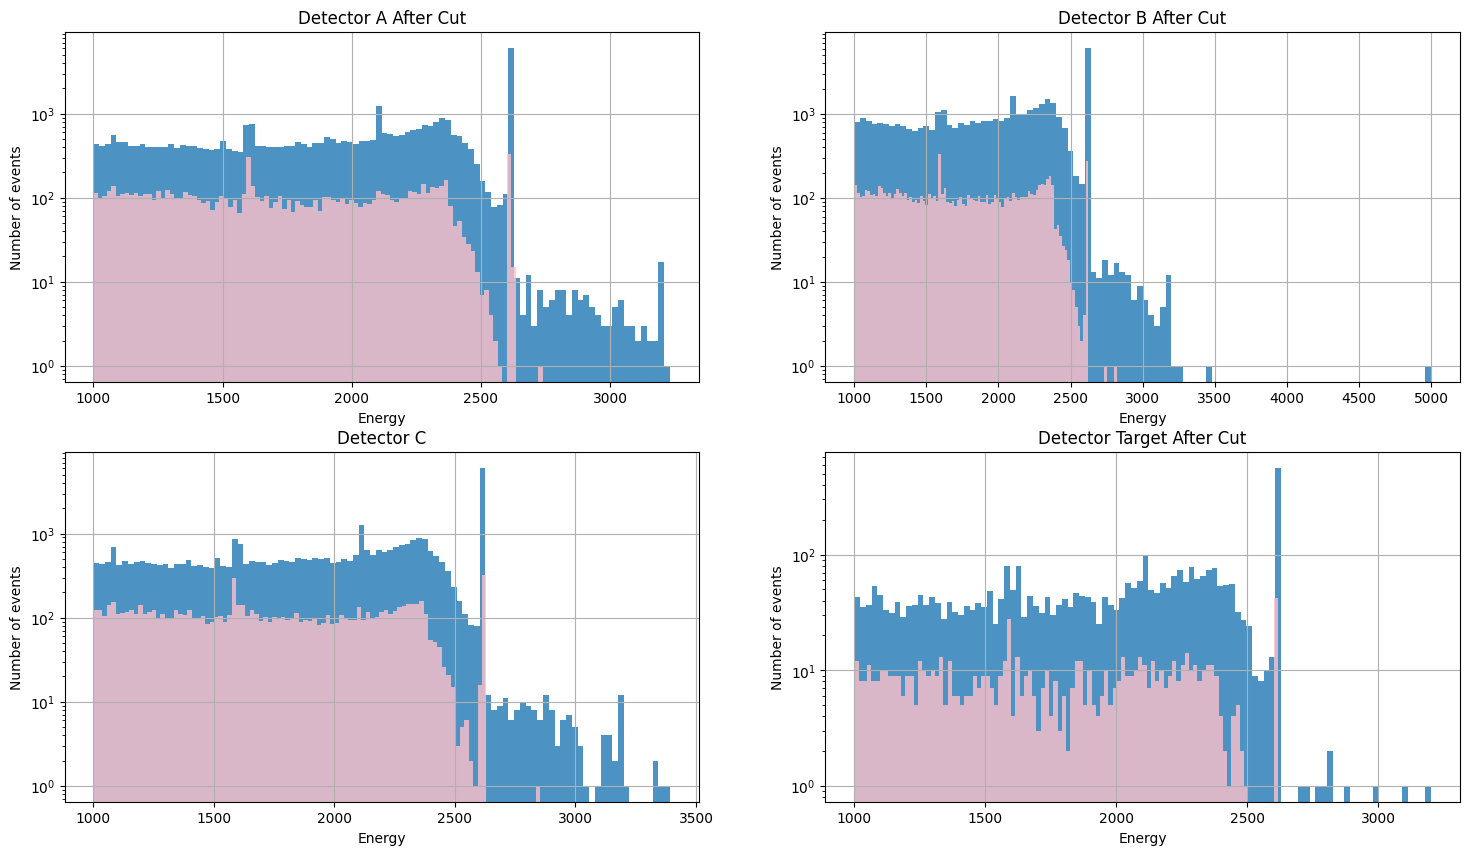

In [63]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8)
plt.hist(detectorA_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8)
plt.hist(detectorB_cut["Energy"], bins=100, alpha=0.8,  color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8)
plt.hist(detectorC_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8)
plt.hist(target_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut')
plt.grid(True)

### Uniform PDF

In [82]:
from scipy.stats import uniform

# Fit uniform distribution to data
locA, scaleA = uniform.fit(detectorA_cut['Energy'])
locB, scaleB = uniform.fit(detectorB_cut['Energy'])
locC, scaleC = uniform.fit(detectorC_cut['Energy'])
locT, scaleT = uniform.fit(target_cut['Energy'])

# Generate x values for plotting the PDF
xA = np.linspace(min(detectorA_cut['Energy'])-1, max(detectorA_cut['Energy'])+1, 1000)
xB = np.linspace(min(detectorB_cut['Energy'])-1, max(detectorB_cut['Energy'])+1, 1000)
xC = np.linspace(min(detectorC_cut['Energy'])-1, max(detectorC_cut['Energy'])+1, 1000)
xT = np.linspace(min(target_cut['Energy'])-1, max(target_cut['Energy'])+1, 1000)

# Get the PDF values
pdfA = uniform.pdf(xA, loc=locA, scale=scaleA)
pdfB = uniform.pdf(xB, loc=locB, scale=scaleB)
pdfC = uniform.pdf(xC, loc=locC, scale=scaleC)
pdfT = uniform.pdf(xT, loc=locT, scale=scaleT)


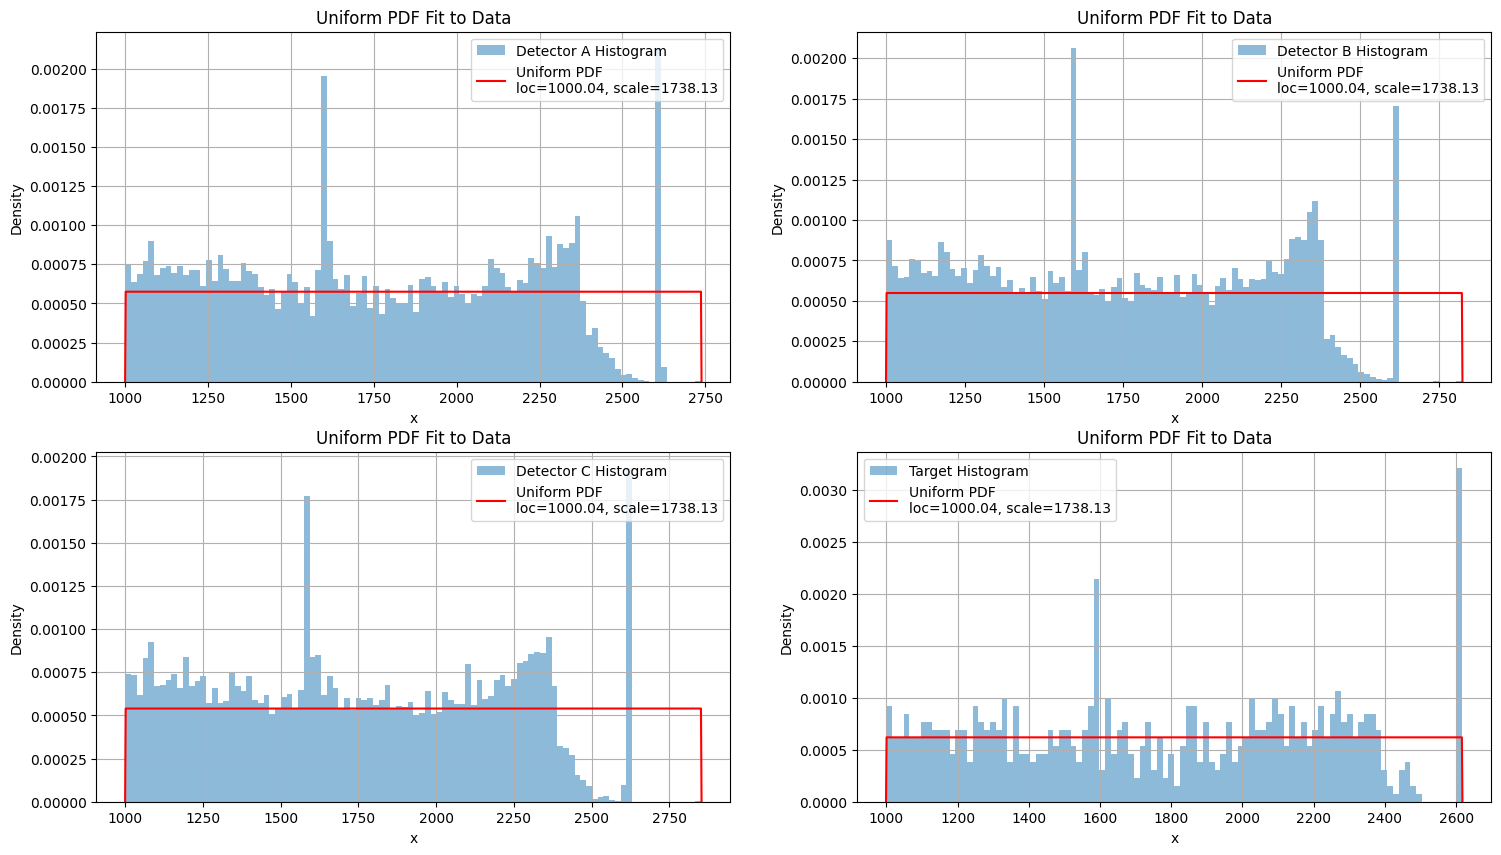

In [83]:
plt.figure(figsize=(18, 10))
# Plot
plt.subplot(2, 2, 1)
plt.hist(detectorA_cut['Energy'], bins=100, density=True, alpha=0.5, label='Detector A Histogram')
plt.plot(xA, pdfA, 'r-', label=f'Uniform PDF\nloc={loc:.2f}, scale={scale:.2f}')
plt.title("Uniform PDF Fit to Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detectorB_cut['Energy'], bins=100, density=True, alpha=0.5, label='Detector B Histogram')
plt.plot(xB, pdfB, 'r-', label=f'Uniform PDF\nloc={loc:.2f}, scale={scale:.2f}')
plt.title("Uniform PDF Fit to Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detectorC_cut['Energy'], bins=100, density=True, alpha=0.5, label='Detector C Histogram')
plt.plot(xC, pdfC, 'r-', label=f'Uniform PDF\nloc={loc:.2f}, scale={scale:.2f}')
plt.title("Uniform PDF Fit to Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(target_cut['Energy'], bins=100, density=True, alpha=0.5, label='Target Histogram')
plt.plot(xT, pdfT, 'r-', label=f'Uniform PDF\nloc={loc:.2f}, scale={scale:.2f}')
plt.title("Uniform PDF Fit to Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.show()

### Gaussian PDF

In [ ]:
from statistics import NormalDist

normA = NormalDist.from_samples(detectorA_cut['Energy'])
normB = NormalDist.from_samples(detectorB_cut['Energy'])
normC = NormalDist.from_samples(detectorC_cut['Energy'])
normTarget = NormalDist.from_samples(target_cut['Energy'])

In [13]:
pdfA_x = np.linspace(normA.mean - 3*normA.stdev, normA.mean + 3*normA.stdev, 100) 
pdfA_values = norm.pdf(pdfA_x, normA.mean, normA.stdev)

pdfB_x = np.linspace(normB.mean - 3*normB.stdev, normB.mean + 3*normB.stdev, 100) 
pdfB_values = norm.pdf(pdfB_x, normB.mean, normB.stdev)

pdfC_x = np.linspace(normC.mean - 3*normC.stdev, normC.mean + 3*normC.stdev, 100) 
pdfC_values = norm.pdf(pdfC_x, normC.mean, normC.stdev)

pdfTarget_x = np.linspace(normTarget.mean - 3*normTarget.stdev, normTarget.mean + 3*normTarget.stdev, 100) 
pdfTarget_values = norm.pdf(pdfTarget_x, normTarget.mean, normTarget.stdev)

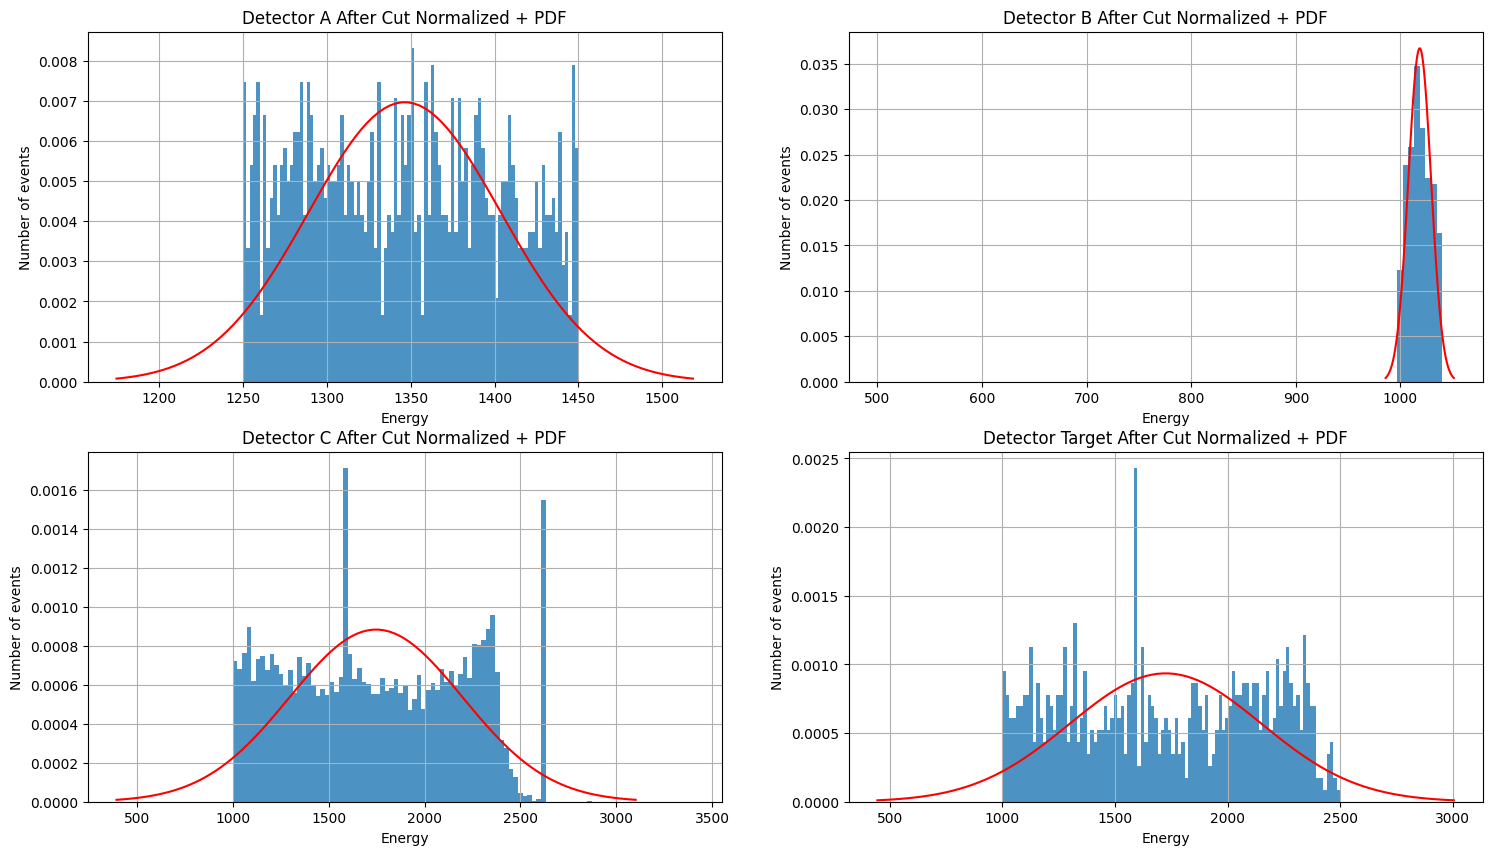

In [85]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detectorA_cut["Energy"], density=True,  bins=100, alpha=0.8, range=(A_cut_range[0], A_cut_range[1]))
plt.plot(pdfA_x, pdfA_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detectorB_cut["Energy"], density=True, bins=100, alpha=0.8, range=(B_cut_range[0], B_cut_range[1]))
plt.plot(pdfB_x, pdfB_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detectorC_cut["Energy"], density=True, bins=100, alpha=0.8, range=(C_cut_range[0], C_cut_range[1]))
plt.plot(pdfC_x, pdfC_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(target_cut["Energy"], density=True, bins=100, alpha=0.8, range=(target_cut_range[0], target_cut_range[1]))
plt.plot(pdfTarget_x, pdfTarget_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut Normalized + PDF')
plt.grid(True)

In [15]:
print("mean of A: ", normA.mean)
print("mean of B: ", normB.mean)
print("mean of C: ", normC.mean)
print("mean of target: ", normTarget.mean)

mean of A:  1346.3971470099668
mean of B:  1018.3904963235294
mean of C:  1747.1672975270478
mean of target:  1725.0094213263978


In [16]:
 # Update Gaussian priors using NormalDist statistics

prior_thetaA = norm(loc=normA.mean, scale=normA.stdev)
prior_thetaB = norm(loc=normB.mean, scale=normB.stdev)
prior_thetaC = norm(loc=normC.mean, scale=normC.stdev)
prior_thetaNLDBD = norm(loc=2039, scale=1)

energy_bins = np.linspace(target_cut["Energy"].min(), target_cut["Energy"].max(), 100)
energy_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
# print(energy_centers)

# Histogram for observed counts
observed_counts, _ = np.histogram(target_cut["Energy"], bins=energy_bins)
# print(observed_counts)

# Model function using energy_centers
def model(thetaA, thetaB, thetaC, thetaNLDBD):
    return (
        thetaA * prior_thetaA.pdf(energy_centers) +
        thetaB * prior_thetaB.pdf(energy_centers) +
        thetaC * prior_thetaC.pdf(energy_centers) +
        thetaNLDBD * prior_thetaNLDBD.pdf(energy_centers)
    )

In [17]:
def log_likelihood(params):
    thetaA, thetaB, thetaC, thetaNLDBD = params
    if any(param < 0 for param in params):
        return -np.inf  # Reject negative values

    model_counts = model(thetaA, thetaB, thetaC, thetaNLDBD)
    likelihood = scipy.stats.poisson.logpmf(observed_counts, model_counts)
    
    return np.sum(likelihood)

# Log-prior function using updated priors
def log_prior(params):
    thetaA, thetaB, thetaC, thetaNLDBD = params
    if any(param < 0 for param in params):
        return -np.inf
    return (
        prior_thetaA.logpdf(thetaA) +
        prior_thetaB.logpdf(thetaB) +
        prior_thetaC.logpdf(thetaC) +
        prior_thetaNLDBD.logpdf(thetaNLDBD)
    )

# Posterior function
def log_posterior(thetaA, thetaB, thetaC, thetaNLDBD):
    params = [thetaA, thetaB, thetaC, thetaNLDBD]
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)


In [18]:
import functools
import inspect
import emcee

def wrap(func, **kwargs):
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=64, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

In [19]:
# Run MCMC sampling
random_state = np.random.RandomState(20)
results = MCMC_sample(
    log_posterior, 
    thetaA=[1350, lambda x: prior_thetaA.logpdf(x)], 
    thetaB=[770, lambda x: prior_thetaB.logpdf(x)], 
    thetaC=[1500, lambda x: prior_thetaC.logpdf(x)], 
    thetaNLDBD=[2039, lambda x: prior_thetaNLDBD.logpdf(x)], 
    # nsamples=20000,
    random_state=random_state
)

# Show summary
print(results.describe())

            thetaA       thetaB       thetaC   thetaNLDBD
count  1000.000000  1000.000000  1000.000000  1000.000000
mean   1375.994907  1013.718251  5490.038478  2039.649834
std      64.180408    13.181841   613.772040     1.557427
min    1166.164557   982.438423  3575.109123  2035.593004
25%    1341.429192  1004.986965  5103.551618  2038.445232
50%    1371.685695  1012.687918  5522.142053  2039.565597
75%    1414.069069  1020.208112  5935.308534  2040.703205
max    1562.978290  1066.500604  6786.547146  2046.250147


Upper limit for thetaNLDBD (90% CI): 2042.193555734955


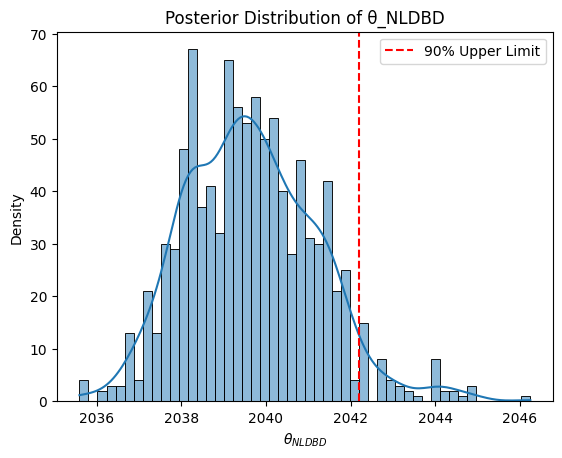

In [20]:
thetaA_samples = results['thetaA']
thetaB_samples = results['thetaB']
thetaC_samples = results['thetaC']
thetaNLDBD_samples = results['thetaNLDBD']

def credible_interval(samples, confidence_level=0.90):
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    return np.percentile(samples, [lower_percentile, upper_percentile])

# Compute 90% credible intervals for each parameter
ci_thetaA = credible_interval(thetaA_samples)
ci_thetaB = credible_interval(thetaB_samples)
ci_thetaC = credible_interval(thetaC_samples)
ci_thetaNLDBD = credible_interval(thetaNLDBD_samples)

# Extract upper bound for θ_NLDBD
upper_limit_thetaNLDBD = ci_thetaNLDBD[1]

print(f"Upper limit for thetaNLDBD (90% CI): {upper_limit_thetaNLDBD}")

# Plot posterior distribution of θ_NLDBD
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(thetaNLDBD_samples, kde=True, bins=50)
plt.axvline(upper_limit_thetaNLDBD, color='red', linestyle='--', label='90% Upper Limit')
plt.xlabel(r'$\theta_{NLDBD}$')
plt.ylabel('Density')
plt.title('Posterior Distribution of θ_NLDBD')
plt.legend()
plt.show()


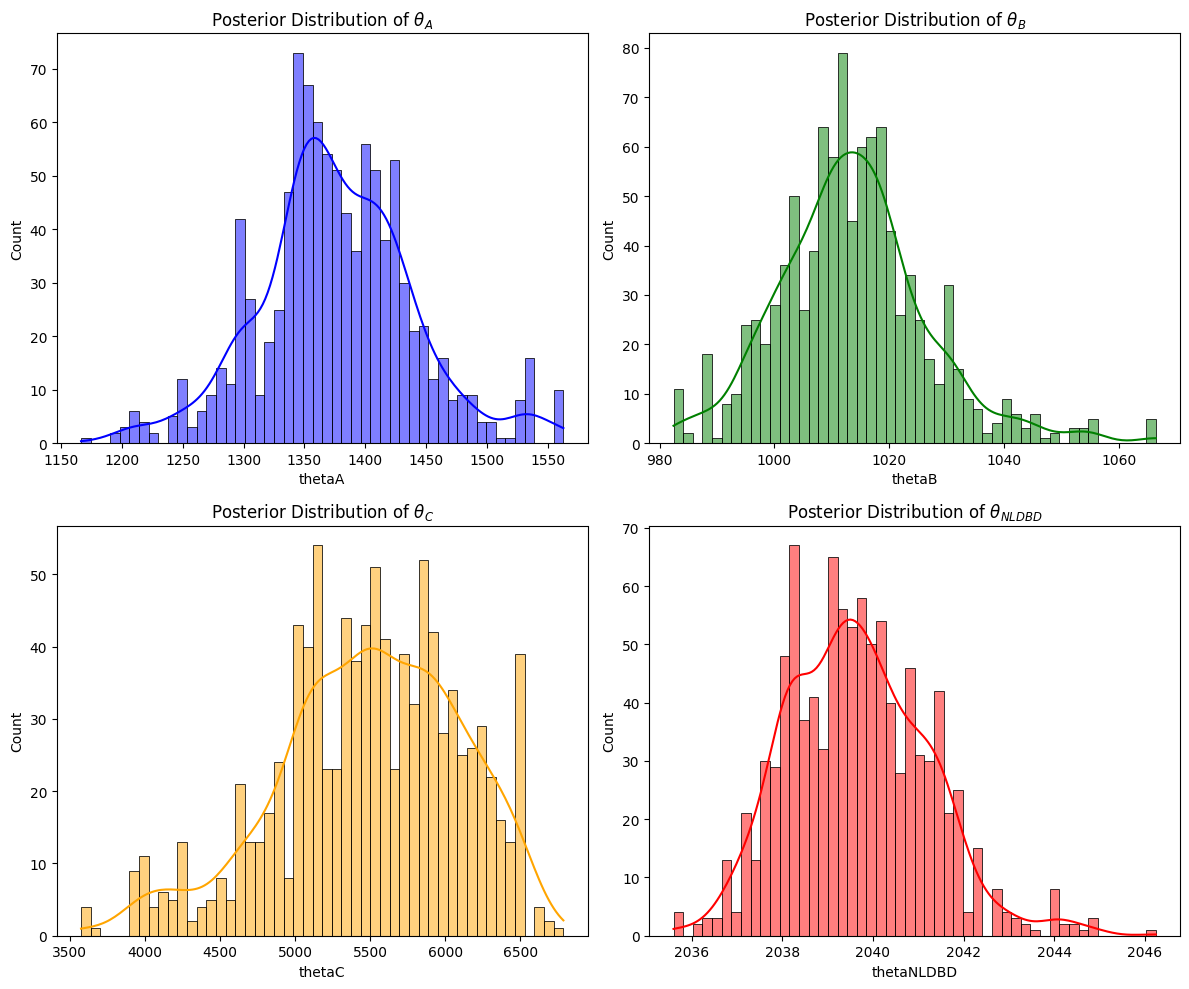

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting posterior distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(results['thetaA'], kde=True, ax=axs[0, 0], bins=50, color='blue')
axs[0, 0].set_title(r'Posterior Distribution of $\theta_A$')

sns.histplot(results['thetaB'], kde=True, ax=axs[0, 1], bins=50, color='green')
axs[0, 1].set_title(r'Posterior Distribution of $\theta_B$')

sns.histplot(results['thetaC'], kde=True, ax=axs[1, 0], bins=50, color='orange')
axs[1, 0].set_title(r'Posterior Distribution of $\theta_C$')

sns.histplot(results['thetaNLDBD'], kde=True, ax=axs[1, 1], bins=50, color='red')
axs[1, 1].set_title(r'Posterior Distribution of $\theta_{NLDBD}$')

plt.tight_layout()
plt.show()


## Checking the fit

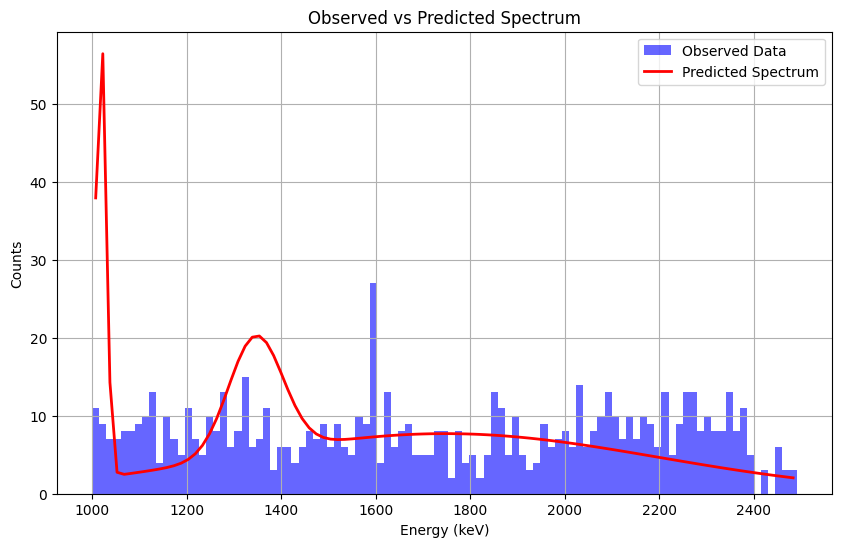

In [22]:
# Get median parameter values from the MCMC samples
thetaA_median = np.median(results['thetaA'])
thetaB_median = np.median(results['thetaB'])
thetaC_median = np.median(results['thetaC'])
thetaNLDBD_median = np.median(results['thetaNLDBD'])

# Generate the predicted spectrum using these values
predicted_counts = model(thetaA_median, thetaB_median, thetaC_median, thetaNLDBD_median)
predicted_counts *= np.sum(observed_counts) / np.sum(predicted_counts)

plt.figure(figsize=(10, 6))

# Plot observed data
plt.hist(target_cut["Energy"], bins=energy_bins, alpha=0.6, color='blue', label='Observed Data')

# Plot predicted data
plt.plot(energy_centers, predicted_counts, color='red', linewidth=2, label='Predicted Spectrum')

plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Observed vs Predicted Spectrum')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Avoid division by zero by replacing zeros in predicted counts with a small value
predicted_counts = np.where(predicted_counts == 0, 1e-10, predicted_counts)

# Calculate chi-square
chi_square = np.sum((observed_counts - predicted_counts) ** 2 / predicted_counts)
dof = len(observed_counts) - 4  # 4 parameters (thetaA, thetaB, thetaC, thetaNLDBD)

print(f"Chi-Square: {chi_square:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"Reduced Chi-Square: {chi_square / dof:.2f}")


Chi-Square: 542.84
Degrees of Freedom: 95
Reduced Chi-Square: 5.71


## Part 8

From the lecture slides we assume 

In [88]:
min([A_min_energy, B_min_energy, C_min_energy])

np.float64(1000.012)

In [89]:
max([A_max_energy, B_max_energy,  C_max_energy])

np.float64(4998.508)

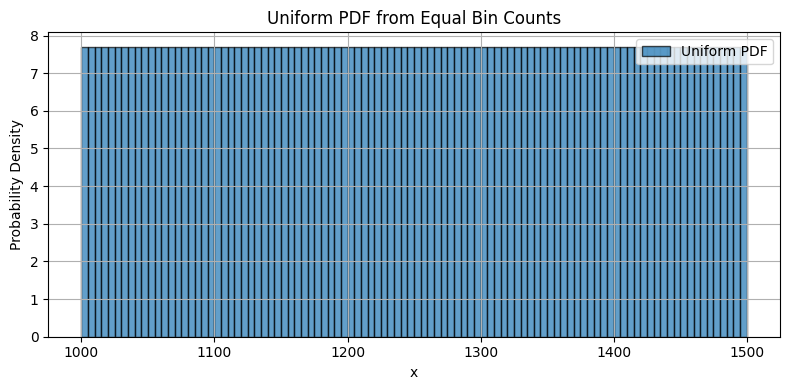

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 1000           # Start of range
b = 1500        # End of range
num_bins = 100   # Number of bins
events_per_bin = 7.7  # Events in each bin

# Derived
bin_edges = np.linspace(a, b, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]
total_events = events_per_bin * num_bins

# Uniform histogram (raw counts)
pdf_values = np.full(num_bins, events_per_bin)

# # Normalize to get PDF
# pdf_values = hist_counts / (total_events * bin_width)

# Plot
plt.figure(figsize=(8, 4))
plt.bar(bin_centers, pdf_values, width=bin_width, edgecolor='black', alpha=0.7, label='Uniform PDF')
plt.title('Uniform PDF from Equal Bin Counts')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
pdf_values

array([7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7,
       7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7])

### Asimov new version

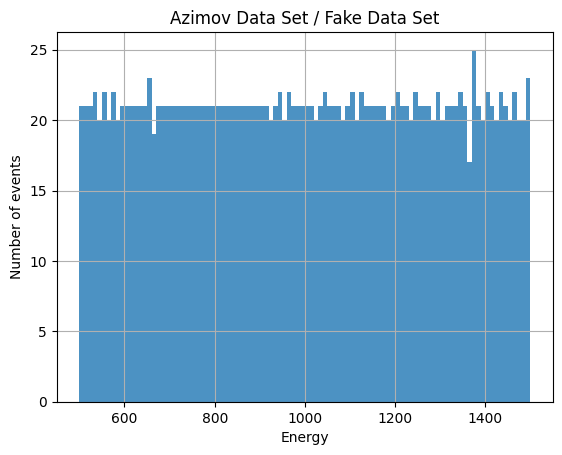

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Define the range and number of bins
azimov_range = [500, 1500]
azimov_x = np.linspace(azimov_range[0], azimov_range[1], 101)
bin_num_events = 21

# Function to generate Azimov data
def gen_azimov_data(azimov_x, bin_num_events):
    azimov_y = []
    for i in range(len(azimov_x) - 1):
        # Generate random numbers uniformly distributed between azimov_x[i] and azimov_x[i+1]
        uniform_samples = np.random.uniform(azimov_x[i], azimov_x[i+1], bin_num_events)
        azimov_y.extend(uniform_samples)
    return azimov_y

# Generate the Azimov data
azimov_y = gen_azimov_data(azimov_x, bin_num_events)

# Plot the histogram
plt.hist(azimov_y, bins=100, alpha=0.8)
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Azimov Data Set / Fake Data Set')
plt.grid(True)
plt.show()

In [86]:
# Define prior for fake data
prior_theta_FakeData = norm(loc=norm_FakeData.mean, scale=norm_FakeData.stdev)

# Define priors for other parameters
prior_thetaA = norm(loc=normA.mean, scale=normA.stdev)
prior_thetaC = norm(loc=normC.mean, scale=normC.stdev)
prior_thetaNLDBD = norm(loc=2039, scale=1)

# Define energy bins and centers
energy_bins = np.linspace(target_cut["Energy"].min(), target_cut["Energy"].max(), 100)
energy_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

# Histogram for observed counts
observed_counts, _ = np.histogram(target_cut["Energy"], bins=energy_bins)

# Model function with fake data for thetaB
def model(thetaA, thetaB, thetaC, thetaNLDBD):
    return (
        thetaA * prior_thetaA.pdf(energy_centers) +
        thetaB * prior_theta_FakeData.pdf(energy_centers) +  # Use fake data for thetaB
        thetaC * prior_thetaC.pdf(energy_centers) +
        thetaNLDBD * prior_thetaNLDBD.pdf(energy_centers)
    )

# Log-likelihood function
def log_likelihood(params):
    thetaA, thetaB, thetaC, thetaNLDBD = params
    if any(param < 0 for param in params):
        return -np.inf  # Reject negative values

    model_counts = model(thetaA, thetaB, thetaC, thetaNLDBD)
    likelihood = scipy.stats.poisson.logpmf(observed_counts, model_counts)
    
    return np.sum(likelihood)

# Log-prior function
def log_prior(params):
    thetaA, thetaB, thetaC, thetaNLDBD = params
    if any(param < 0 for param in params):
        return -np.inf
    return (
        prior_thetaA.logpdf(thetaA) +
        prior_theta_FakeData.logpdf(thetaB) +  # Use fake data prior for thetaB
        prior_thetaC.logpdf(thetaC) +
        prior_thetaNLDBD.logpdf(thetaNLDBD)
    )

# Posterior function
def log_posterior(thetaA, thetaB, thetaC, thetaNLDBD):
    params = [thetaA, thetaB, thetaC, thetaNLDBD]
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

# Run MCMC sampling
# random_state = np.random.RandomState(2)
results_fake = MCMC_sample(
    log_posterior,
    # thetaA=[1350, lambda x: prior_thetaA.logpdf(x)],
    thetaB=[norm_FakeData.mean, lambda x: prior_theta_FakeData.logpdf(x)],  # Use fake data for thetaB
    # thetaC=[1500, lambda x: prior_thetaC.logpdf(x)],
    # thetaNLDBD=[2039, lambda x: prior_thetaNLDBD.logpdf(x)],
    random_state=random_state
)

# Show summary
print(results_fake.describe())

thetaNLDBD_samples = results_fake['thetaNLDBD']

# Compute 90% credible intervals
def credible_interval(samples, confidence_level=0.90):
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    return np.percentile(samples, [lower_percentile, upper_percentile])

ci_thetaNLDBD = credible_interval(thetaNLDBD_samples)
upper_limit_thetaNLDBD = ci_thetaNLDBD[1]
print(f"Upper limit for thetaNLDBD (90% CI): {upper_limit_thetaNLDBD}")

# Plot posterior distribution of thetaNLDBD
import seaborn as sns
sns.histplot(thetaNLDBD_samples, kde=True, bins=50)
plt.axvline(upper_limit_thetaNLDBD, color='red', linestyle='--', label='90% Upper Limit')
plt.xlabel(r'$\theta_{NLDBD}$')
plt.ylabel('Density')
plt.title('Posterior Distribution of θ_NLDBD')
plt.legend()
plt.show()

ValueError: Missing arguments.